In [52]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys, os, time, math
import string
from joblib import dump, load
from datetime import date
import itertools 
import scipy 


In [2]:
n_conditions = 5 # Number of ligand conditions aka times (t1, t2, t3, ..., tn) 
n_macrostates = 5 # Number of Macro states 
n_executions = 20 # Clustering repetition
n_microstates = 100 # To comply with n_microstates = n_states * n_executions
today = date.today()
date2day = today.strftime("%b%d-%Y")
sys_name = 'toyModel_continuum_'

In [13]:
def Covariance_matrix(sigma_x, sigma_y):
    covariance = [sigma_x, sigma_y]  # Covariance matrix
    # Calculate the eigenvalues
    eigenvalues, _ = np.linalg.eig(covariance)
    
    # Check if all eigenvalues are non-negative
    positive_semidefinite = np.all(eigenvalues >= 0)
    if positive_semidefinite:
       print("Eigenvalues of Covariance matrix:", eigenvalues)
       print("Is the covariance matrix positive semidefinite?", positive_semidefinite)
    else:
       print("Is the covariance matrix positive semidefinite?", positive_semidefinite)
       sys.exit(0) 
    return covariance 

In [4]:
def mean_2d(x, y):
    mu_x = np.mean(x)
    mu_y = np.mean(y)
    mean = [mu_x, mu_y]
    
    return mean


In [5]:
# Calculate a Gaussian distribution with a given mean and variance 
def Gaussian_distribution(mean, covariance, positions):

    # Calculate the Gaussian distribution on the grid
    Gaussian = np.exp(-0.5 * (np.einsum('...k,kl,...l->...',
                                     positions-mean, np.linalg.inv(covariance), positions-mean)))
    Gaussian /= 2.0 * np.pi * np.sqrt(np.linalg.det(covariance))
    
    return Gaussian


In [6]:
sigma_x = [4.15, 1.56]
sigma_y = [2.53, 3.78]
covariance = Covariance_matrix(sigma_x, sigma_y) # Covariance matrix

x_start, x_end, x_step = -25, 25, 0.05
y_start, y_end, y_step = -25, 25, 0.05

# Create the Mesh grid
x, y = np.mgrid[x_start:x_end:x_step, y_start:y_end:y_step]

# Generate grid points
positions = np.empty(x.shape + (2, ))
positions[:, :, 0] = x
positions[:, :, 1] = y

x_vec = np.arange(x_start, x_end, x_step)
y_vec = np.arange(y_start, y_end, y_step)

#mean = mean_2d(x_vec, y_vec)
mean = [5.0, 7.0]

Gauss_dist = Gaussian_distribution(mean, covariance, positions)


Eigenvalues of Covariance matrix: [5.96025061 1.96974939]
Is the covariance matrix positive semidefinite? True


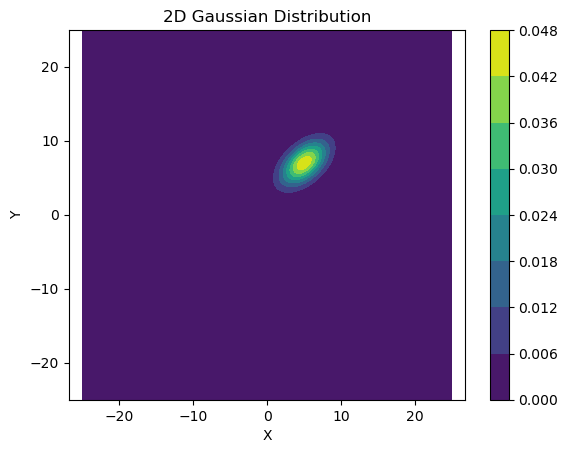

In [7]:
# Plotting
plt.contourf(x, y, Gauss_dist)
plt.colorbar()
plt.title('2D Gaussian Distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()

In [14]:
# Compute Gaussian distribution at multiple positions
def microstate_RNA_levels_multGauss(sigma_x, sigma_y, n_Gaussians):
    
    x_start, x_end, x_step = -0.5, 0.5, 0.1
    y_start, y_end, y_step = -0.5, 0.5, 0.1

    # Create the Mesh grid
    x, y = np.mgrid[x_start:x_end:x_step, y_start:y_end:y_step]

    # Generate grid points
    positions = np.empty(x.shape + (2, ))
    positions[:, :, 0] = x
    positions[:, :, 1] = y
    
    # Initialize the mixture distribution
    mixture = np.zeros(x.shape)

    covariance = Covariance_matrix(sigma_x, sigma_y)
    # Base covariance matrix
    base_covariance = np.array(covariance)

    # Define parameters for n_Gaussians different Gaussians
    for i in range(n_Gaussians):
        mean_loc = [np.random.uniform(x_start, x_end), np.random.uniform(y_start, y_end)]
        
        # Create a variation of the base covariance matrix
        scale_factor = np.random.uniform(0.8, 1.40)  # Scale factor between 0.5 and 1.5 for variation
        covariance_variation = np.random.uniform(0.9, 1.1, size=(2, 2))  # Slight random perturbation
        covariance_loc = base_covariance * scale_factor * covariance_variation

        # Ensure covariance_loc remains symmetric and positive semidefinite
        covariance_loc = (covariance_loc + covariance_loc.T) / 2.0
        
        # Compute the Gaussian distribution for each Gaussian and add it to the mixture
        mixture += Gaussian_distribution(np.array(mean_loc), covariance_loc, positions)

    return x, y, mixture


In [22]:
# Generate RNA level data to mimic the experiments by convoluting multiple Gaussians
n_Gaussians = 5
sigma_x = [0.38, 0.26]; sigma_y = [0.24, 0.35]
x_rna, y_rna, mGaussRNAlevels = microstate_RNA_levels_multGauss(sigma_x, sigma_y, n_Gaussians)
print(mGaussRNAlevels.shape)

Eigenvalues of Covariance matrix: [0.61524988 0.11475012]
Is the covariance matrix positive semidefinite? True
(10, 10)


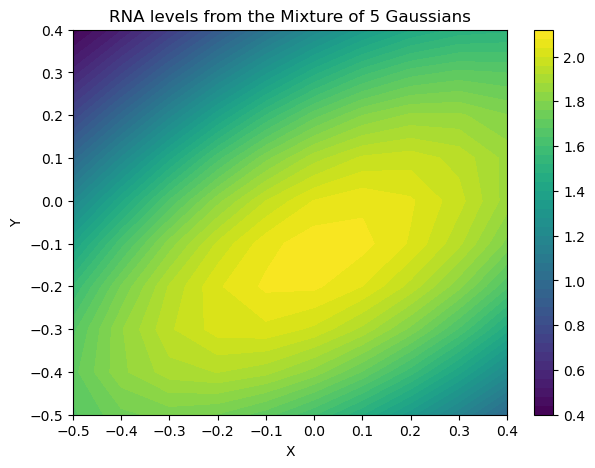

In [23]:
# Plotting
plt.figure(figsize = (7, 5))
plt.contourf(x_rna, y_rna, mGaussRNAlevels, levels = 50, cmap = 'viridis')
plt.colorbar()
plt.title(f'RNA levels from the Mixture of {n_Gaussians} Gaussians')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [24]:
# Reshape the pos array into two dimensions
pos_reshaped = positions.reshape(-1, 2)

##### Cluster single-cell trajectories of a given snippet length by using KMeans from deeptime 
from deeptime.clustering import KMeans
model = KMeans(n_clusters = n_microstates,  # place 100 cluster centers
               init_strategy = 'kmeans++',  # kmeans++ initialization strategy
               max_iter = 0,
               fixed_seed = 13)  # don't actually perform the optimization, just place centers
               
################################ Initial clustering ###############################
clustering = model.fit(pos_reshaped).fetch_model()  

model.initial_centers = clustering.cluster_centers
model.max_iter = 5000
clusters = model.fit(pos_reshaped).fetch_model()  


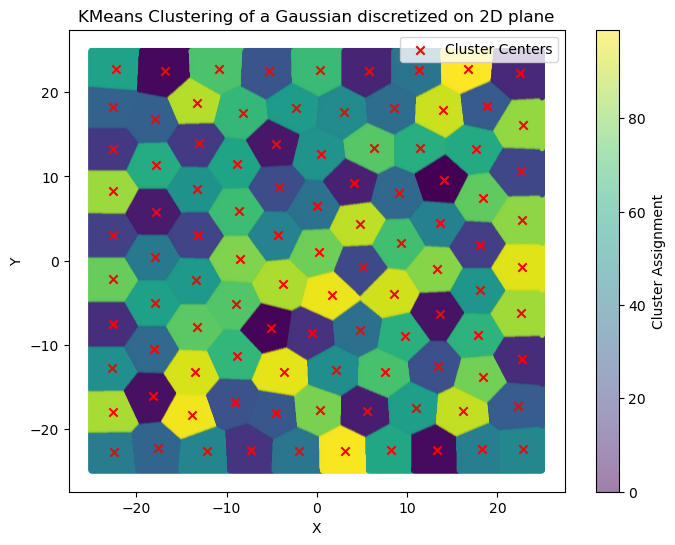

In [25]:
from scipy.spatial.distance import cdist
# Extract cluster assignments and centers
cluster_centers = clusters.cluster_centers
# Assign each point to the nearest cluster center
distances = cdist(pos_reshaped, cluster_centers, 'euclidean')
cluster_assignments = np.argmin(distances, axis=1)

# Reshaped plotting
x_plot, y_plot = pos_reshaped[:, 0], pos_reshaped[:, 1]

# Plotting
plt.figure(figsize=(8, 6))
scatter_plot = plt.scatter(x_plot, y_plot, c=cluster_assignments, cmap='viridis', alpha=0.5, marker='.')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', label='Cluster Centers')
plt.title(f'KMeans Clustering of a Gaussian discretized on 2D plane')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc = 'upper right')
# Adding a colorbar
plt.colorbar(scatter_plot, label='Cluster Assignment')
plt.show()


In [26]:
# Count the number of points in each cluster
cluster_counts = np.bincount(cluster_assignments, minlength = n_microstates)

# Calculate the total number of points
total_points = cluster_assignments.size

# Calculate fractional populations
fractional_populations = cluster_counts / total_points
# Print the fractional populations
#for i, fraction in enumerate(fractional_populations):
#   print(f"Population: {cluster_counts[i]} and Fractional population of Cluster {i}: {fraction:.6f}")

In [27]:
# Flatten Gauss_dist to match the shape of pos_reshaped
Gauss_dist_flattened = Gauss_dist.reshape(-1)
# Initialize an array for average densities
n_clusters = cluster_centers.shape[0]
average_densities = np.zeros(n_clusters)

# Calculate average density for each cluster
for i in range(n_clusters):
    indices = np.where(cluster_assignments == i)[0]
    if len(indices) > 0:  # Ensure there are points assigned to the cluster
        average_densities[i] = np.mean(Gauss_dist_flattened[indices])


In [28]:
# Initialize the transition matrix
transition_matrix = np.zeros((n_clusters, n_clusters))

for i in range(n_clusters):
    for j in range(n_clusters):
        if i != j:
            # Simple model: inversely proportional to the absolute density difference
            density_diff = np.abs(average_densities[i] - average_densities[j])
            transition_matrix[i, j] = 1 / (1 + density_diff)
        else:
            # Simplistic self-transition probability
            transition_matrix[i, j] = 1.0

# Normalize the transition matrix so each row sums to 1
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)


In [29]:
n_trajectories = 3  # Number of trajectories
n_steps = n_microstates  # Number of steps in each trajectory

def simulate_trajectory(transition_matrix, n_steps, start_state=None):
    if start_state is None:
        current_state = np.random.choice(n_clusters)  # Random initial state
    else:
        current_state = start_state  # Or start from a predefined state

    trajectory = [current_state]
    for _ in range(1, n_steps):
        next_state = np.random.choice(a=n_clusters, p=transition_matrix[current_state])
        trajectory.append(next_state)
        current_state = next_state

    return trajectory

# Generate multiple 'n_trajectories' trajectories
trajectories = [simulate_trajectory(transition_matrix, n_steps) for _ in range(n_trajectories)]


In [30]:
n_clusters = n_microstates  # Number of clusters/states

# Initialize a matrix to count transitions
transition_counts = np.zeros((n_clusters, n_clusters))

# Count transitions for each trajectory
for traj in trajectories:
    for i in range(len(traj) - 1):
        current_state = traj[i]
        next_state = traj[i + 1]
        transition_counts[current_state, next_state] += 1

# Convert counts to probabilities
transition_probabilities = np.zeros_like(transition_counts)
for i in range(n_clusters):
    total_transitions = np.sum(transition_counts[i])
    if total_transitions > 0:  # Avoid division by zero
        transition_probabilities[i] = transition_counts[i] / total_transitions
# transition_probabilities now contains the refined transition probabilities


In [31]:
# Assuming the'fractional_populations' is an array of populations per cluster
initial_distribution = np.array(fractional_populations) # Initial probability distribution

# Function to calculate the distribution at time t
def time_evolution_init_dist(initial_distribution, transition_matrix, t):
    return np.dot(initial_distribution, np.linalg.matrix_power(transition_matrix, t))

# Calculate the distribution at different times
times = [1, 2, 3, 4, 5]
probability_distribution_t = []
for t, time in enumerate(times):
    distribution_t = time_evolution_init_dist(initial_distribution, transition_probabilities, time)
    probability_distribution_t.append(distribution_t)
    #print(f"Distribution at t = {time}:", distribution_t)


In [32]:
# "Biologically" important components of the transition matrix 
def bio_essential_comps_transition_matrix(eigen_values, eigen_vectors, n_components = 20):
    
    v_real = np.multiply(eigen_values[-n_components:], np.real(eigen_vectors[:, -n_components:]))
    v_imaginary = np.multiply(eigen_values[-n_components:], np.imag(eigen_vectors[:, -n_components:]))
    v_kinetics = np.append(v_real, v_imaginary, axis = 1)

    return v_kinetics

In [33]:
tMat = transition_probabilities.copy()
# Find Eigenvalues and Eigenvectors of the transition matrix "tMat"
H = .5*(tMat + np.transpose(tMat)) + .5j*(tMat - np.transpose(tMat))
eigenvals, eigenvecs = np.linalg.eig(H)  
eigenvals_real = np.real(eigenvals)
indsort = np.argsort(eigenvals_real)
eigenvals_real = eigenvals_real[indsort] # Eigenvalues
eigenvecs = eigenvecs[:, indsort] # Eigenvectors
n_comp_tmat = 25 # Keep last "n_comp" eigenvectors of the transition matrix

# Keep "Biologically" important components of the transition matrix 
vkin = bio_essential_comps_transition_matrix(eigenvals_real, eigenvecs, n_components = n_comp_tmat)


In [ ]:
plt.scatter(eigenvals.real, eigenvals.imag, color='blue')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Eigenvalues of Transition Matrix')
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.grid(True, which='both', ls='--', lw=0.5)
plt.axis('equal')  # Ensure the unit circle looks circular
plt.show()

In [34]:
from scipy.spatial import distance_matrix
from sklearn.metrics import adjusted_rand_score

def custom_clustering(vkin, initial_points):
    # Calculate the distance from each point in vkin to each initial point (centroid)
    dists = distance_matrix(vkin, initial_points)
    
    # Assign each point to the nearest centroid
    nearest_centroid_indices = np.argmin(dists, axis=1)
    
    return nearest_centroid_indices

def unique_multi_iterative_clustering(vkin, n_clusters, n_iterations=10, n_executions=10, ari_threshold=1.0):
    accepted_clusterings = []
    execution = 0
    while len(accepted_clusterings) < n_executions:
        # Re-initialize centroids (Macro cluster centers) randomly for each execution
        np.random.seed(execution)  # Different seed for each execution
        # Re-initialize centroids randomly
        initial_points = vkin[np.random.choice(np.arange(len(vkin)), size=n_clusters, replace=False), :]
        
        for _ in range(n_iterations):
            # Assign clusters and update centroids
            cluster_assignments = custom_clustering(vkin, initial_points)
            for i in range(n_clusters):
                points_in_cluster = vkin[cluster_assignments == i]
                if points_in_cluster.size > 0:
                    initial_points[i] = np.mean(points_in_cluster, axis=0)

        # Check the new clustering against all accepted clusterings for uniqueness
        is_unique = True
        for previous_assignments in accepted_clusterings:
            ari_score = adjusted_rand_score(cluster_assignments, previous_assignments)
            if ari_score > ari_threshold:
                is_unique = False
                break  # The new clustering is too similar to a previous one, discard it

        if is_unique:
            accepted_clusterings.append(cluster_assignments)  # Accept the new clustering
        execution += 1
            
    return accepted_clusterings


In [35]:
# Cluster multiple times and check if the states are unique  
clusters_vkin = unique_multi_iterative_clustering(vkin, n_macrostates,
                                                  n_iterations = 10,
                                                  n_executions = n_executions)


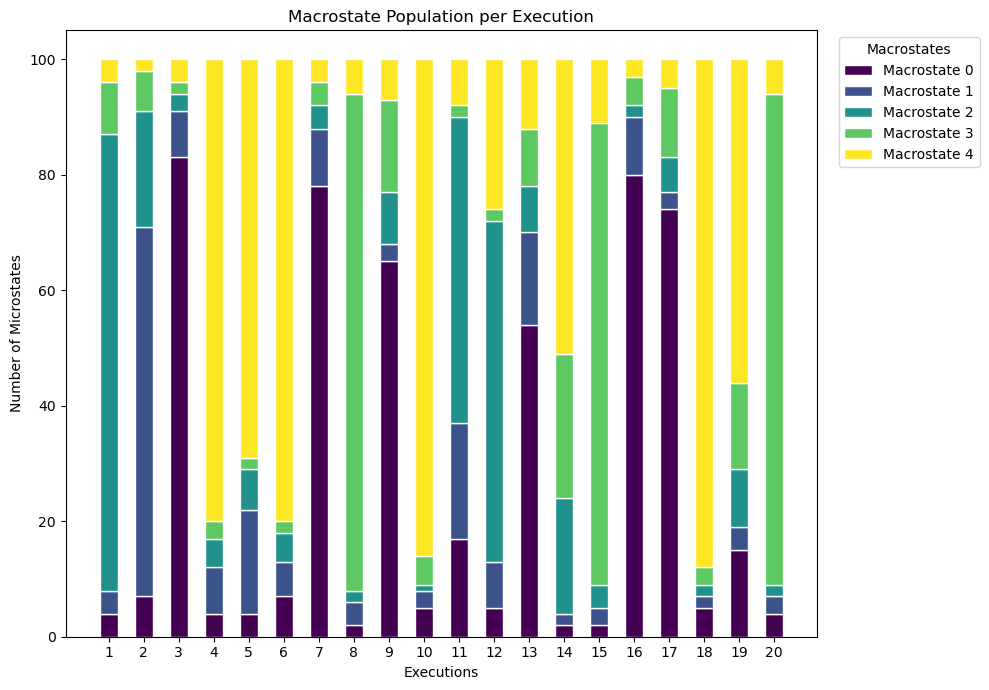

In [36]:
# Initialize a matrix to hold the count of microstates for each macrostate in each execution
cluster_populations_visual = np.zeros((n_executions, n_macrostates))

# Count microstates for each macrostate in each execution
for execution, assignments_visual in enumerate(clusters_vkin):
    cluster_counts_visual = np.bincount(assignments_visual, minlength=n_macrostates)
    cluster_populations_visual[execution, :] = cluster_counts_visual

# Colors for each macrostate
colors = plt.cm.viridis(np.linspace(0, 1, n_macrostates))

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))

# Creating the stacked bar chart
for i in range(n_macrostates):
    # Extracting the population for macrostate i across all executions
    macrostate_population_visual = cluster_populations_visual[:, i]
    
    # Bottom parameter for the bar plot, to stack the macrostates
    if i == 0:
        bottoms = np.zeros(n_executions)
    else:
        bottoms += cluster_populations_visual[:, i-1]
    
    ax.bar(range(n_executions), macrostate_population_visual, bottom=bottoms,
           color=colors[i], edgecolor='white', width=0.5, label=f'Macrostate {i}')

ax.set_xlabel('Executions')
ax.set_ylabel('Number of Microstates')
ax.set_title('Macrostate Population per Execution')
ax.set_xticks(range(n_executions))
ax.set_xticklabels([f'{i+1}' for i in range(n_executions)])
ax.legend(title="Macrostates", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.decomposition import PCA 
from IPython.display import clear_output
pca_vkin = PCA(n_components = 2)
vkin_reduced = pca_vkin.fit_transform(vkin)

for indExc in range(n_executions):
    clear_output(wait = True)
    plt.clf()
    plt.figure(figsize = (7, 5))
    for i in range(n_macrostates):
        plt.scatter(vkin_reduced[clusters_vkin[indExc] == i, 0],
                    vkin_reduced[clusters_vkin[indExc] == i, 1], label=f'Cluster {i}')
    plt.legend(loc = 'best')
    plt.title(f'PCA Projection of Microstates Execution: {indExc+1}')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.pause(0.33)

<Figure size 640x480 with 0 Axes>

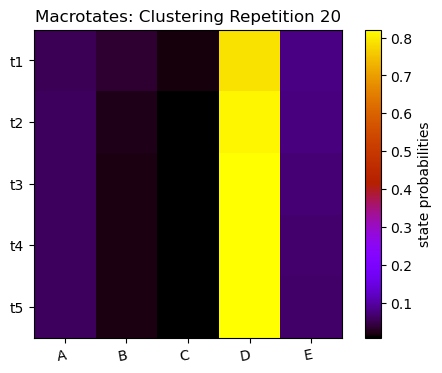

In [40]:
from IPython.display import clear_output
t_sets = ['t1', 't2', 't3', 't4', 't5']
t_sets = np.array(t_sets)
state_labels = np.array(list(string.ascii_uppercase))[0:n_macrostates]
state_order = np.arange(n_macrostates).astype(int)
cluster_macrostate_probs = [] # Macrostate probabilities of all cluster repetitions 
for iEx in range(n_executions):
    macrostate_probs = np.zeros((n_conditions, n_macrostates))
    # Get transition probability distribution at different times 
    for time_idx, distribution_t in enumerate(probability_distribution_t):
        # Aggregate distribution_t into macrostate probabilities
        for microstate_idx, prob in enumerate(distribution_t):
             macrostate = clusters_vkin[iEx][microstate_idx] # Find the macrostate for this cluster
             macrostate_probs[time_idx, macrostate] += prob  # Aggregate probabilities that belong to respective macro cluster 
    
    cluster_macrostate_probs.append(macrostate_probs)
    clear_output(wait = True)
    plt.clf()
    plt.figure(figsize = (6, 4))
    plt.imshow(macrostate_probs[:, state_order], cmap=plt.cm.gnuplot)
    cbar = plt.colorbar()
    cbar.set_label('state probabilities')
    # We want to show all ticks...
    ax = plt.gca()
    ax.set_yticks(np.arange(n_conditions))
    ax.set_xticks(np.arange(n_macrostates))
    ax.set_xticklabels(np.array(state_labels)[state_order])
    ax.set_title(f'Macrotates: Clustering Repetition {iEx+1}')
    ax.set_yticklabels(t_sets)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=10, ha="right",rotation_mode="anchor")
    plt.pause(.33);


In [45]:
def bulk_rna_levels(probability_distribution_t, microstate_rna_levels, n_conditions):

    bulk_rna = []
    
    for time_ind, distribution_t in enumerate(probability_distribution_t):
        bulk_rna_local = 0.
        for microstate_ind, prob in enumerate(distribution_t):  
            bulk_rna_local += prob*microstate_rna_levels[microstate_ind]
        bulk_rna.append(bulk_rna_local)
    
    bulk_rna = np.array(bulk_rna)    
    return bulk_rna

# RNA levels generated by using multiple Gaussians for "n_microstates"
microstate_rna_levels = mGaussRNAlevels.reshape(-1, 1) 
# Calculate bulk RNA levels 
bulk_rna_levels = bulk_rna_levels(probability_distribution_t, microstate_rna_levels, n_conditions)

In [46]:
def get_macrostate_decomposition(x_fc, state_probs, ncombinations=500,
                                 save_file=None, visual=False,
                                 verbose=True, nchunk=100):
    nStates = state_probs.shape[1] # number of morphodynamic (Macro) states
    n_conds = state_probs.shape[0] # set conditions
    nGenes = x_fc.shape[1]
    measured_rna_synd = x_fc.shape[0] # fold-change values of RNA levels for "n_microstates"
    
    x_fc_states = np.ones((nStates, nGenes))*np.nan
    inds_conds = np.arange(n_conds).astype(int)
    comb_trainarray = np.array(list(itertools.combinations(inds_conds, nStates)))
    ncomb = comb_trainarray.shape[0]
    print(f'{ncomb} possible combinations of {n_conds} training measurements decomposed into {nStates} states')
    if ncombinations > ncomb:
        ncombinations = ncomb
    print(f'using {ncombinations} of {ncomb} possible training set combinations randomly per feature')
    for ig in range(nGenes): # LOOP OVER NUMBER OF GENES
        # Generate a uniform random sequence from np.arange(ncomb) of size "ncombinations"
        indr = np.random.choice(ncomb, ncombinations, replace=False)
        if ig%nchunk == 0 and verbose:
            print(f'decomposing gene {ig} of {nGenes}')
            if save_file is not None:
                np.save(save_file, x_fc_states)
        v_states_comb = np.zeros((ncombinations, nStates))
        for icomb in range(ncombinations):
            indcomb = comb_trainarray[indr[icomb]] # Pick randomized index to remove bias 
            v_treatments = x_fc[indcomb, ig] # Pick a ligand condition randomly and use its RNA levels
            # Least square linear optimization for each Gene --> solving state_probs*x = v_treatments (fold-change)  
            res = scipy.optimize.lsq_linear(state_probs[indcomb, :], v_treatments, bounds=(lb, ub), verbose=1)
            v_states_comb[icomb, :] = res.x.copy() # x (contribution of each state) is returned from scipy.optimize.lsq_linear 
        v_states = np.mean(v_states_comb, axis=0)
        x_fc_states[:, ig] = v_states.copy() # log-fold change of a selected gene across morphodynamic states
        if ig%nchunk == 0 and visual:
            plt.clf()
            plt.plot(v_states_comb.T, 'k.')
            plt.plot(v_states.T, 'b-', linewidth=2)
            if gene_names is None:
                plt.title(f'{ig} of {nGenes}')
            else:
                plt.title(str(gene_names.iloc[ig])+' gene '+str(ig)+' of '+str(nGenes))
            plt.pause(.1)
    if save_file is not None:
        np.save(save_file, x_fc_states)
    return x_fc_states


In [64]:
 # Cluster RNA levels by repetition of clustering multiple times 
x_fc_states_exec = np.zeros((n_executions, n_macrostates))
prob_microstates = np.zeros((n_microstates, n_microstates))
visual = False
state_count = 0
# Calculate Gene levels 
for ind_ex in range(n_executions):
    
        state_probs = cluster_macrostate_probs[ind_ex]
        lb = np.zeros(n_macrostates)
        ub = np.ones(n_macrostates)*np.inf
        
        get_counts = True
        if get_counts:
            x_fc_states = get_macrostate_decomposition(bulk_rna_levels, state_probs, ncombinations=500, 
                                                  save_file=None, visual=visual)
        else:
            x_fc_states = np.load('macrostates_foldchange_'+figid+'.npy')
             
        x_fc_states_exec[ind_ex, :] = x_fc_states[:, 0]
        # x_lfc_predicted = np.log2(x_fc_predicted) # Convert from fold-change to log fold-change
        # state_names = np.array(list(string.ascii_uppercase))[0:nStates]
        
        # Get transition probability corresponding to microstates & times 
        for time_idx, distribution_t in enumerate(probability_distribution_t):
        # Aggregate distribution_t into macrostate probabilities
             for microstate_idx, prob in enumerate(distribution_t):
                 macrostate = clusters_vkin[iEx][microstate_idx] # Find the macrostate for this cluster
                 indc_cluster = macrostate + state_count
                 prob_microstates[indc_cluster][microstate_idx] = prob
        state_count += int(n_macrostates)

1 possible combinations of 5 training measurements decomposed into 5 states
using 1 of 1 possible training set combinations randomly per feature
decomposing gene 0 of 1
The first-order optimality measure is less than `tol`.
Number of iterations 11, initial cost 2.7741e-01, final cost 1.9948e-05, first-order optimality 3.48e-12.
1 possible combinations of 5 training measurements decomposed into 5 states
using 1 of 1 possible training set combinations randomly per feature
decomposing gene 0 of 1
The first-order optimality measure is less than `tol`.
Number of iterations 9, initial cost 1.0956e-01, final cost 1.8146e-08, first-order optimality 9.30e-11.
1 possible combinations of 5 training measurements decomposed into 5 states
using 1 of 1 possible training set combinations randomly per feature
decomposing gene 0 of 1
The first-order optimality measure is less than `tol`.
Number of iterations 17, initial cost 1.1057e+01, final cost 1.2717e-05, first-order optimality 9.55e-12.
1 possible 

In [76]:
####### Calculate microstate RNA levels from the cluster RNA levels ####### 
x_fc_states_exec_reshaped = x_fc_states_exec.reshape(-1, 1)
b = np.array(x_fc_states_exec_reshaped[:, 0])
A = np.array(prob_microstates)
# Solve for b = A*x, where 'x' is microstate RNA levels 
microstate_rna_levels_pred, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
#print(microstate_rna_levels_pred)

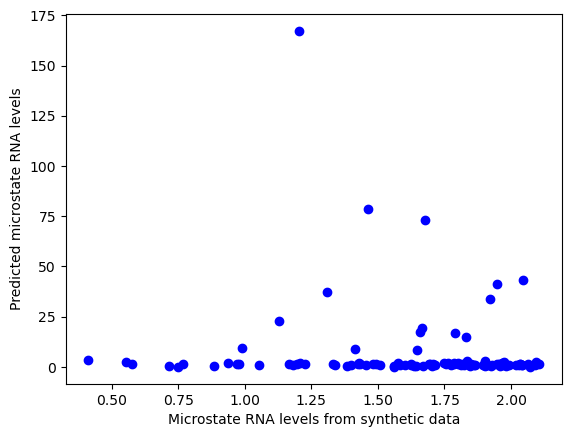

In [77]:
plt.scatter(microstate_rna_levels, microstate_rna_levels_pred, color='b', marker='o')
plt.xlabel('Microstate RNA levels from synthetic data')
plt.ylabel('Predicted microstate RNA levels')
plt.show()